In [ ]:
 # let's get a dataset
import pandas as pd
from sklearn.model_selection import train_test_split
path = "https://raw.githubusercontent.com/Shivanandroy/T5-Finetuning-PyTorch/main/data/news_summary.csv"
df = pd.read_csv(path)
df=df.head(30)

In [ ]:
df=pd.read_csv("summarycsv.csv")

In [ ]:
df.shape

(9, 2)

In [ ]:
df.columns=['summary','text']

In [ ]:
df=df.head(30)

In [ ]:
df.head()

,summary,text
0,Chlorophyll is a green pigment present in plan...,Chlorophyll is the green pigment present in al...
1,Chlorophyll is a pigment present in photosynth...,Chlorophyll is a pigment present in photosynth...
2,Chlorophyll is a green pigment found in plants...,Chlorophyll is a green photosynthetic pigment ...
3,Chlorophyll is a green pigment responsible for...,Chlorophyll is a green colour pigment which is...
4,It is a green pigment present in chloroplasts....,It's a green pigment which is present in the c...


In [ ]:
# train_df,test_df=train_test_split(df)
train_df,test_df=train_test_split(df,test_size=0.1)
#pytorch-lightning==1.2.2

In [ ]:
!pip uninstall torchtext

In [ ]:
!pip install torch
!pip install transformers==4.5.0
# !pip install tokenizers==0.9.4
# !pip install sentencepiece==0.1.94

In [ ]:
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning


  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-h43tf7fs
  Running command git clone -q https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-h43tf7fs
  Running command git submodule update --init --recursive -q
  From https://github.com/PyTorchLightning/lightning-tutorials
   * branch            290fb466de1fcc2ac6025f74b56906592911e856 -> FETCH_HEAD
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
import pytorch_lightning as pl
print(pl.__version__)

1.7.0dev


In [ ]:
#  !pip install torchtext==0.8.0

In [ ]:
import json
import pandas as pd
import numpy as np
import torch
import pathlib as Path
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from termcolor import colored
import textwrap

In [ ]:
from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer
)
from tqdm.auto import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

In [ ]:
pl.seed_everything(42)

Global seed set to 42


42

In [ ]:
df.head()

,summary,text
0,Chlorophyll is a green pigment present in plan...,Chlorophyll is the green pigment present in al...
1,Chlorophyll is a pigment present in photosynth...,Chlorophyll is a pigment present in photosynth...
2,Chlorophyll is a green pigment found in plants...,Chlorophyll is a green photosynthetic pigment ...
3,Chlorophyll is a green pigment responsible for...,Chlorophyll is a green colour pigment which is...
4,It is a green pigment present in chloroplasts....,It's a green pigment which is present in the c...


In [ ]:
#
class ExamSummaryDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: T5Tokenizer,
        text_max_token_len: int = 512,
        summary_max_token_len: int = 128
        ):
        self.tokenizer = tokenizer
        self.data = data
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        text = data_row['text']

        text_encoding = tokenizer(
            text,
            max_length=self.text_max_token_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt'
        )

        summary_encoding = tokenizer(
            data_row['summary'],
            max_length=self.summary_max_token_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt'
        )

        labels = summary_encoding['input_ids']
        labels[labels == 0] = -100 # to make sure we have correct labels for T5 text generation

        return dict(
            text=text,
            summary=data_row['summary'],
            text_input_ids=text_encoding['input_ids'].flatten(),
            text_attention_mask=text_encoding['attention_mask'].flatten(),
            labels=labels.flatten(),
            labels_attention_mask=summary_encoding['attention_mask'].flatten()
        )

In [ ]:
class SummaryDataModule(pl.LightningDataModule):
    
    def __init__(
        self,
        train_df: pd.DataFrame,
        test_df: pd.DataFrame,
        tokenizer: T5Tokenizer,
        batch_size: int = 8,
        text_max_token_len: int = 512,
        summary_max_token_len: int = 128
    ):
        super().__init__()

        self.train_df = train_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len

    def setup(self, stage=None):
        self.train_dataset = ExamSummaryDataset(
            self.train_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )
        self.test_dataset = ExamSummaryDataset(
            self.test_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

In [ ]:
MODEL_NAME = 't5-small'
tokenizer=T5Tokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [ ]:
text_token_counts, summary_token_counts = [],[]

for _, row in train_df.iterrows():
    text_token_count=len(tokenizer.encode(row["text"]))
    text_token_counts.append(text_token_count)

    summary_token_count=len(tokenizer.encode(row["summary"]))
    summary_token_counts.append(summary_token_count)

Text(0.5, 1.0, 'summary Text token counts')

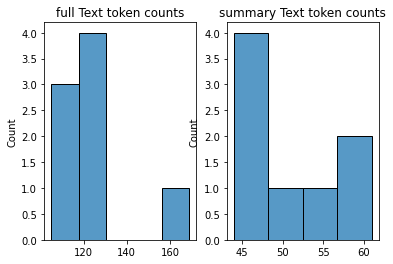

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
sns.histplot(text_token_counts,ax=ax1)
ax1.set_title("full Text token counts")

sns.histplot(summary_token_counts, ax=ax2)
ax2.set_title("summary Text token counts")


In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 1

data_module = SummaryDataModule(train_df,test_df,tokenizer, batch_size=BATCH_SIZE)

# MODEL

In [ ]:
class SummaryModel(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
    
    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )

        return output.loss, output.logits

    def training_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)

In [ ]:
model = SummaryModel()

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/242M [00:00<?, ?B/s]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

<IPython.core.display.Javascript object>

In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

logger = TensorBoardLogger("lightning_logs", name='news-summary')

trainer = pl.Trainer(
    logger=logger,
    callbacks=[checkpoint_callback],
    max_epochs=N_EPOCHS,
    gpus=1)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:425: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model,data_module)

Missing logger folder: lightning_logs/news-summary
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
242.026   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1889: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 8: 'val_loss' reached 1.66451 (best 1.66451), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 16: 'val_loss' reached 1.52532 (best 1.52532), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 24: 'val_loss' reached 1.45710 (best 1.45710), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 32: 'val_loss' reached 1.43352 (best 1.43352), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 40: 'val_loss' reached 1.41480 (best 1.41480), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 48: 'val_loss' reached 1.35579 (best 1.35579), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 56: 'val_loss' reached 1.30228 (best 1.30228), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 64: 'val_loss' reached 1.26255 (best 1.26255), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 72: 'val_loss' reached 1.24407 (best 1.24407), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 80: 'val_loss' was not in top 1


In [ ]:
trained_model=SummaryModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)
trained_model.freeze()

In [ ]:
def summarizeText(text):
    text_encoding = tokenizer(
        text,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )
    generated_ids = trained_model.model.generate(
        input_ids=text_encoding['input_ids'],
        attention_mask=text_encoding['attention_mask'],
        min_length=30,
        max_length=100,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )

    preds = [
            tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            for gen_id in generated_ids
    ]
    return "".join(preds)


In [ ]:
sample_row = df.iloc[0]
text = sample_row['text']
model_summary = summarizeText(text)
text

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1777: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


'Chlorophyll is\xa0the green pigment present in all the green plants and trees and in some algae as well. It is responsible for the green color of the plants. An arrangement of chlorophyll in groups is known as chloroplast. It absorbs sunlight, which is one of the most important thing for photosynthesis.  Inside every plant cell are chloroplasts. They contain a green pigment called chlorophyll. Chlorophyll conducts photosynthesis. That is the process which uses water and carbon dioxide to produce glucose. Plants use glucose for energy.\n'

In [ ]:
model_summary

'Chlorophyll is a green pigment present in plants and algae. It absorbs sunlight, which is one of the most important things for photosynthesis. It uses water and carbon dioxide to produce glucose. It is responsible for the green color of plants.'

In [ ]:
from google.colab import files
files.download("/content/checkpoints/best-checkpoint.ckpt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>